# Analyse Suraj's qPCR data

In [1]:
# The goal is to re-threshold the results and see if that makes them more consistent

In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import linregress

In [3]:
folder = 'Y:/Suraj/qPCR Data/'

In [4]:
raw_file = '2020-10-22_134431_LAMIN_KI_qPCR_1 RAW.xlsx'

In [5]:
raw = pd.read_excel(folder+raw_file, header=None, sheet_name=None)

In [6]:
# header_position
header_position = 45

In [7]:
def get_dataframe(sheet, header_position):
    
    new_header = sheet.loc[header_position].copy()
    new_header.name = None
    
    df = sheet.iloc[header_position+1:, :].copy()
    df.columns = new_header
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [8]:
# Get sheet names
sheet_names = list(raw.keys())
sheet_names

['Sample Setup',
 'Raw Data',
 'Amplification Data',
 'Multicomponent Data',
 'Results',
 'Melt Curve Raw Data',
 'Melt Curve Result',
 'Reagent Information']

In [9]:
# Sample Setup contains no information

In [10]:
#my_sample_df = pd.read_csv('C:/Users/David Brown/Desktop/qPCR Map.csv')

In [11]:
#Drop Unnamed columns
# my_sample_df = my_sample_df.drop(columns=list(my_sample_df.columns[my_sample_df.columns.str.contains('Unnamed')]))
# my_sample_df.head()

,Well,Well Position,Sample Name,Sample Color,Biogroup Name,Biogroup Color,Target Name,Target Color,Task,Reporter,Quencher,Quantity,Comments
0,1,A1,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,1fmol,None
1,2,A2,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,0.1fmol,None
2,3,A3,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,0.01fmol,None
3,4,A4,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,0.001fmol,None
4,5,A5,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,0.0001fmol,None


In [12]:
# my_sample_df['Quantity'].unique()

array(['1fmol', '0.1fmol', '0.01fmol', '0.001fmol', '0.0001fmol',
       '0.00001fmol', 'None', 'Unknown'], dtype=object)

In [13]:
# Convert quantity to numeric (in fmols)
# for n, value in my_sample_df['Quantity'].iteritems():
#     if 'fmol' in  value:
#         my_sample_df.loc[n, 'Quantity'] = value.rstrip('fmol')

# my_sample_df['Quantity'] = pd.to_numeric(my_sample_df['Quantity'], errors='coerce')
# my_sample_df

,Well,Well Position,Sample Name,Sample Color,Biogroup Name,Biogroup Color,Target Name,Target Color,Task,Reporter,Quencher,Quantity,Comments
0,1,A1,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,1.0000,None
1,2,A2,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,0.1000,None
2,3,A3,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,0.0100,None
3,4,A4,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,0.0010,None
4,5,A5,WT Plasmid Control,None,WT Plasmid Control,None,LMNA Internal,grey,Standard,None,None,0.0001,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,P20,None,None,None,None,None,None,None,None,None,NaN,None
380,381,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,None,GFP11 in GFP(1-10) Sort,None,GFP11_LMNA,green,Unknown,None,None,NaN,None
381,382,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,None,GFP11 in GFP(1-10) Sort,None,GFP11_LMNA,green,Unknown,None,None,NaN,None
382,383,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,None,GFP11 in GFP(1-10) Sort,None,GFP11_LMNA,green,Unknown,None,None,NaN,None


In [108]:
#Fix 'ALFA-SpyT LMNA Plasmid', by replacing with 'ALFA-SpyT-LMNA Plasmid'
# my_sample_df.replace('ALFA-SpyT LMNA Plasmid', value='ALFA-SpyT-LMNA Plasmid', inplace=True)
# my_sample_df.replace('WT Plasmid Control', value='WT LMNA Plasmid', inplace=True)
# my_sample_df.replace('GS PPI PS', value='GS07 PPI Presort', inplace=True)
# my_sample_df.replace('GS07 PPI ', value='GS07 PPI', inplace=True)
# my_sample_df.replace('AS02 PPI PS', value='AS02 PPI Presort', inplace=True)
# my_sample_df.replace('LP cDNA ', value='LP cDNA', inplace=True)
# my_sample_df.replace('AS02 PPI ', value='AS02 PPI', inplace=True)
# my_sample_df.replace('AS04 PPI ', value='AS04 PPI', inplace=True)

In [109]:
## Save fixed my_sample_df
my_sample_df.to_csv('my_sample_df.csv')

In [17]:
## Load fixed my_sample_df
my_sample_df = pd.read_csv('my_sample_df.csv')

In [110]:
my_sample_df['Biogroup Name'].unique()

array(['WT LMNA Plasmid', 'None', 'AS02 PPI Presort', 'GS07 PPI Presort',
       'AS04 Biallelic PS', 'SpyT-LMNA Plasmid', 'GFP11-LMNA Plasmid',
       'AS02 PPI', 'AS04 PPI', 'GS07 PPI', 'AS04 Biallelic',
       'ALFA-LMNA Plasmid', 'GFP11-SpyT-LMNA Plasmid',
       'ALFA-SpyT-LMNA Plasmid', 'WT HEK293T cDNA', 'LP cDNA',
       'AS04 LP cDNA', 'NTC', 'RTC', 'AS04 LP PPI Sort',
       'AS04 LP Biallelic Sort', 'GFP11 in GFP(1-10) Presort',
       'GFP11 in GFP(1-10) Sort'], dtype=object)

In [19]:
my_sample_df['Target Name'].unique()

array(['LMNA Internal', 'None', 'SpyTag_LMNA', 'GFP11_LMNA', 'ALFA_LMNA'],
      dtype=object)

## Step 1 - Annotate the Amplification Data

In [111]:
amplification_data = raw[sheet_names[2]]

amplification_df = get_dataframe(amplification_data, header_position)
amplification_df

,Well,Well Position,Cycle,Target Name,Rn,Delta Rn
0,1,A1,1,s,39208.7,-888.22
1,1,A1,2,s,39939.5,-410.773
2,1,A1,3,s,40640.1,36.6141
3,1,A1,4,s,40878.5,21.7008
4,1,A1,5,s,40956.8,-153.244
...,...,...,...,...,...,...
15355,384,P24,36,sample,475503,365495
15356,384,P24,37,sample,492822,382932
15357,384,P24,38,sample,506859,397087
15358,384,P24,39,sample,517936,408281


In [112]:
# Annotate raw data with useful information, Sample Name, Biogroup Name, Target Name, Target Color, Task, Quantity
info = my_sample_df.loc[:,['Well Position',
                           'Sample Name',
                           'Biogroup Name', 
                           'Target Name', 
                           'Target Color', 
                           'Task', 
                           'Quantity']]

In [113]:
# Map info onto amplification_data based on 'Well Position'.
amplification_df = amplification_df.merge(info, on='Well Position')
amplification_df.drop(columns=['Target Name_x'], inplace=True)
amplification_df.rename(columns={'Target Name_y':'Target Name'}, inplace=True)
amplification_df

,Well,Well Position,Cycle,Rn,Delta Rn,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity
0,1,A1,1,39208.7,-888.22,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
1,1,A1,2,39939.5,-410.773,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
2,1,A1,3,40640.1,36.6141,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
3,1,A1,4,40878.5,21.7008,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
4,1,A1,5,40956.8,-153.244,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
...,...,...,...,...,...,...,...,...,...,...,...
15355,384,P24,36,475503,365495,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN
15356,384,P24,37,492822,382932,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN
15357,384,P24,38,506859,397087,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN
15358,384,P24,39,517936,408281,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN


In [114]:
# Plot the amplification data by Primer Set
grouped = amplification_df.groupby(by=['Target Name', 'Task', 'Biogroup Name', 'Sample Name', 'Well Position'])

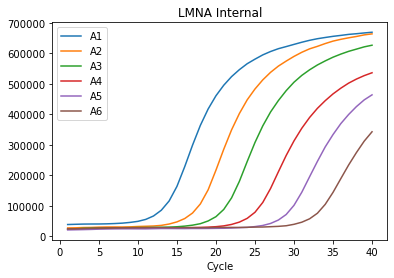

In [115]:
# Plot the amplification data by Primer Set
grouped = amplification_df.groupby(by=['Target Name', 'Task', 'Biogroup Name', 'Sample Name', 'Well Position'])

target_choice = 'LMNA Internal'
task_choice   = 'Standard'

fig, ax = plt.subplots()

for keys, group in grouped:
    
    # get identifiers for each group
    (target, task, biogroup,  sample, well) = keys
    
    if (target == target_choice) and (task == task_choice):
        
        group.plot(x='Cycle', y='Rn', ax=ax, label=well);
        
plt.title(target_choice);
plt.show()

In [116]:
# Plot data of interest based on a dictionary
def plot_subset(df, x, y, conditions: dict):
    
    keys   = list(conditions.keys())
    values = list(conditions.values())
    
    df = df[(df[conditions.keys()] == values).all(1)]
    
    grouped = df.groupby('Well Position')
    
    fig, ax = plt.subplots()

    # Find matching groups
    for well, group in grouped:

        group.plot(x=x, y=y, ax=ax, label=well);

    plt.title(conditions['Target Name']);
    plt.show()

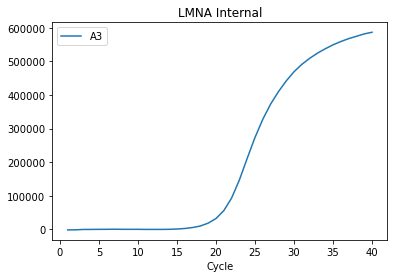

In [117]:
conditions = {'Target Name': 'LMNA Internal', 'Well Position':'A3'}
plot_subset(amplification_df, 'Cycle', 'Delta Rn', conditions)

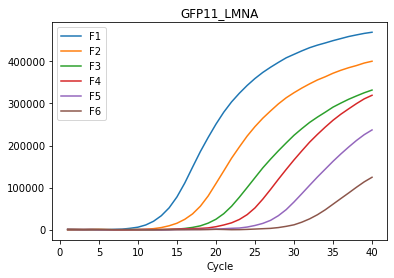

In [118]:
conditions = {'Target Name': 'GFP11_LMNA', 'Biogroup Name':'GFP11-LMNA Plasmid', 'Task':'Standard'}
plot_subset(amplification_df, 'Cycle', 'Delta Rn', conditions)

In [119]:
# def subset_by_options(options, keys):

#     conditions = []

#     for pair in zip(options, keys):
#         conditions.append(if_check(*pair))

#     return tuple(conditions)

# # Check (option, value) pairs match if given.
# def if_check(option, value):
#     if option:
#         return option == value
#     else:
#         return True

# import functools
# def conjunction(*conditions):
#     return functools.reduce(np.logical_and, conditions)

## Step 2 - Re-threshold the data

In [120]:
for n, name in enumerate(sheet_names):
    print(n, name)

0 Sample Setup
1 Raw Data
2 Amplification Data
3 Multicomponent Data
4 Results
5 Melt Curve Raw Data
6 Melt Curve Result
7 Reagent Information


In [121]:
## What are the thresholds that were used?
original_results = raw[sheet_names[4]]

original_results = get_dataframe(original_results, header_position)
original_results

## Annotate original_results
original_results.update(info)

## Still have to add 'Biogroup Name'
original_results = original_results.merge(info.loc[:,['Well Position','Biogroup Name']], on='Well Position')

In [122]:
original_results

,Well,Well Position,Omit,Sample Name,Target Name,Task,Reporter,Quencher,CT,Ct Mean,...,Cq Conf,CQCONF,EXPFAIL,HIGHSD,MTP,Tm1,Tm2,Tm3,Tm4,Biogroup Name
0,1,A1,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,10.7819,23.1243,...,0.917608,N,N,Y,N,85.6508,NaN,NaN,NaN,WT LMNA Plasmid
1,2,A2,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,14.7766,23.1243,...,0.892489,N,N,Y,N,85.6508,NaN,NaN,NaN,WT LMNA Plasmid
2,3,A3,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,18.2721,23.1243,...,0.921872,N,N,Y,N,85.7636,NaN,NaN,NaN,WT LMNA Plasmid
3,4,A4,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,22.4681,23.1243,...,0.969774,N,N,Y,N,85.7636,NaN,NaN,NaN,WT LMNA Plasmid
4,5,A5,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,26.6304,23.1243,...,0.970196,N,N,Y,N,85.8691,NaN,NaN,NaN,WT LMNA Plasmid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,P20,false,None,None,None,SYBR,None,Undetermined,27.6988,...,0,Y,N,N,N,92.5387,NaN,NaN,NaN,None
380,381,P21,false,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11_LMNA,Unknown,SYBR,None,25.5364,27.6988,...,0.988397,N,N,Y,Y,86.9177,79.7982,NaN,NaN,GFP11 in GFP(1-10) Sort
381,382,P22,false,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11_LMNA,Unknown,SYBR,None,25.6383,27.6988,...,0.987371,N,N,Y,Y,86.8047,79.3462,NaN,NaN,GFP11 in GFP(1-10) Sort
382,383,P23,false,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11_LMNA,Unknown,SYBR,None,25.1406,27.6988,...,0.981798,N,N,Y,N,87.0307,NaN,NaN,NaN,GFP11 in GFP(1-10) Sort


In [123]:
original_results.columns

Index(['Well', 'Well Position', 'Omit', 'Sample Name', 'Target Name', 'Task',
       'Reporter', 'Quencher', 'CT', 'Ct Mean', 'Ct SD', 'Quantity',
       'Quantity Mean', 'Quantity SD', 'Y-Intercept', 'R(superscript 2)',
       'Slope', 'Efficiency', 'Automatic Ct Threshold', 'Ct Threshold',
       'Automatic Baseline', 'Baseline Start', 'Baseline End', 'Amp Status',
       'Comments', 'Cq Conf', 'CQCONF', 'EXPFAIL', 'HIGHSD', 'MTP', 'Tm1',
       'Tm2', 'Tm3', 'Tm4', 'Biogroup Name'],
      dtype='object')

In [124]:
original_results[['Well Position', 'Automatic Ct Threshold', 'Ct Threshold']]

,Well Position,Automatic Ct Threshold,Ct Threshold
0,A1,true,11543.6
1,A2,true,11543.6
2,A3,true,11543.6
3,A4,true,11543.6
4,A5,true,11543.6
...,...,...,...
379,P20,true,15593.9
380,P21,true,15593.9
381,P22,true,15593.9
382,P23,true,15593.9


In [125]:
original_results['Ct Threshold'].unique()

array([11543.649907235183, 15593.911055423094], dtype=object)

In [126]:
standard_threshold = original_results['Ct Threshold'].unique()[0]
sample_threshold   = original_results['Ct Threshold'].unique()[1]

In [127]:
def plot_standards(df, x, y, target, by='Biogroup Name'):
    
    grouped = df[(df['Target Name']==target) & (df['Task']=='Standard')].groupby(by)

    for group_name, group in grouped:

        fig, ax = plt.subplots()
        
        thresholds = []

        for well in group['Well Position']:

            amplification_df[amplification_df['Well Position']==well].plot(x, y, ax = ax)
            ax.legend(group['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            
            threshold = original_results[original_results['Well Position']==well]['Ct Threshold'].item()
            thresholds.append(threshold)
            
        # Add unique thresholds to plot
        for threshold in list(set(thresholds)):
            ax.axhline(threshold, c='k', linestyle='--')
            print('threshold=',threshold)

        plt.title(group_name+', '+target+' Primers')
        plt.show()

threshold= 11543.649907235183


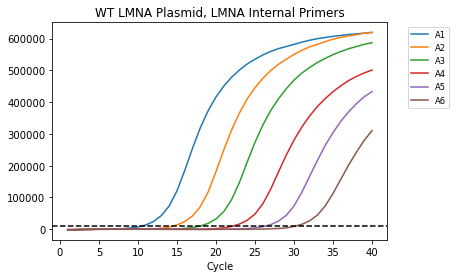

In [128]:
plot_standards(original_results, x='Cycle', y='Delta Rn', target='LMNA Internal', by='Biogroup Name')

threshold= 11543.649907235183


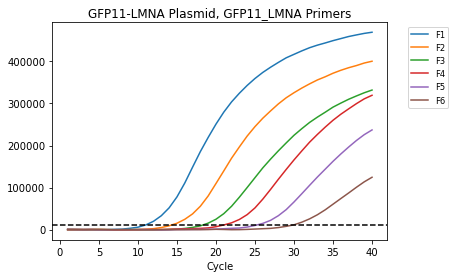

threshold= 11543.649907235183


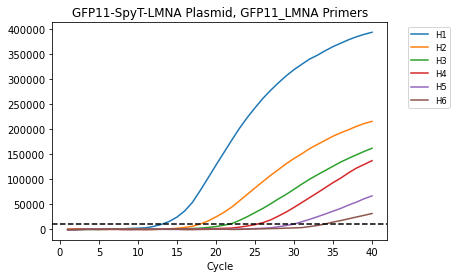

threshold= 11543.649907235183


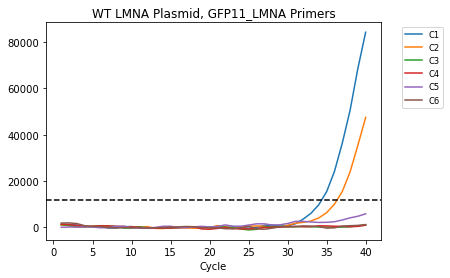

In [129]:
plot_standards(original_results, x='Cycle', y='Delta Rn', target='GFP11_LMNA', by='Biogroup Name')

threshold= 11543.649907235183


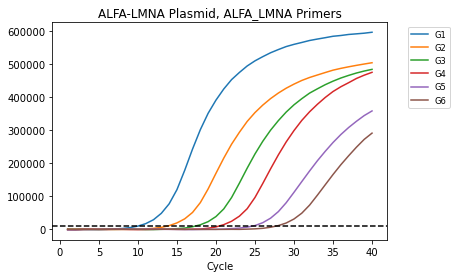

threshold= 11543.649907235183


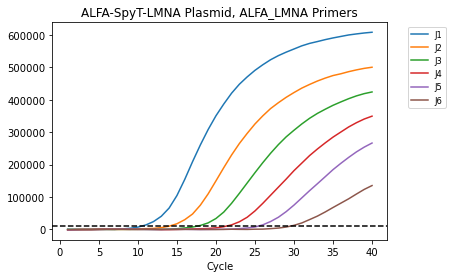

threshold= 11543.649907235183


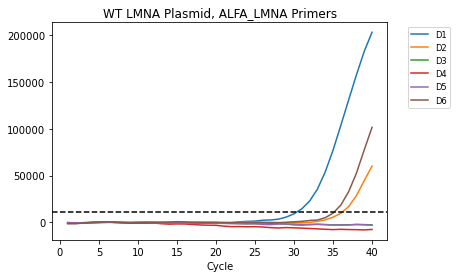

In [130]:
plot_standards(original_results, x='Cycle', y='Delta Rn', target='ALFA_LMNA', by='Biogroup Name')

threshold= 11543.649907235183


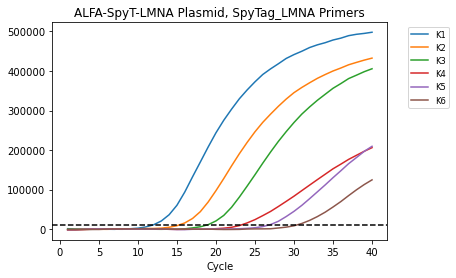

threshold= 11543.649907235183


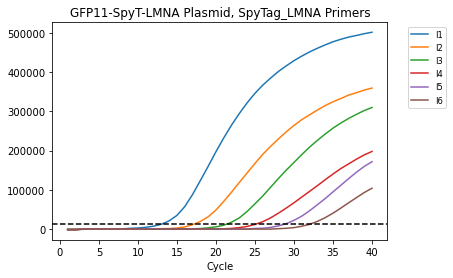

threshold= 11543.649907235183


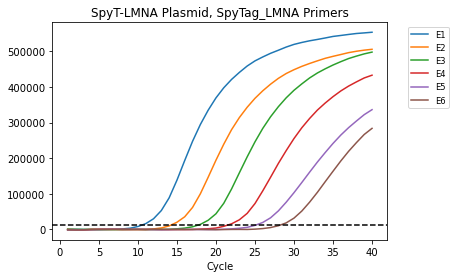

threshold= 11543.649907235183


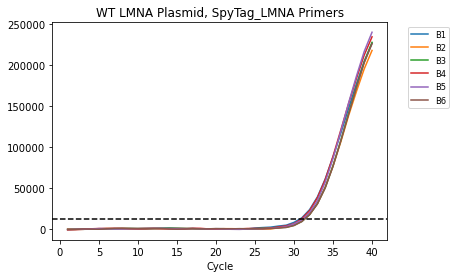

In [131]:
plot_standards(original_results, x='Cycle', y='Delta Rn', target='SpyTag_LMNA', by='Biogroup Name')

In [132]:
## What if we calculate Cts for all wells using the standard_threshold?

In [133]:
# Fit spline
from scipy.interpolate import interp1d

In [134]:
def get_Ct_from_ampdata(xdata, ydata, threshold):
    
    inv_f = interp1d(ydata, xdata, bounds_error=False, fill_value=np.nan)
    
    Ct = inv_f(threshold)
    
    return Ct

In [135]:
def get_Ct_for_well(well, threshold):
    
    xdata = amplification_df[amplification_df['Well Position']==well]['Cycle']
    ydata = amplification_df[amplification_df['Well Position']==well]['Delta Rn']
    
    return get_Ct_from_ampdata(xdata, ydata, threshold)

In [136]:
# Try with some samples
target='LMNA Internal'

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

my_Ct_results                  = pd.DataFrame()
my_Ct_results['Well Position'] = target_wells['Well Position']

Old_Cts       = []
Lo_thresh_Cts = []
Hi_thresh_Cts = []

for well in target_wells['Well Position'].unique():
    xdata = amplification_df[amplification_df['Well Position']==well]['Cycle']
    ydata = amplification_df[amplification_df['Well Position']==well]['Delta Rn']
    
    Old_Ct = original_results[original_results['Well Position']==well]['CT'].item()
    
    Lo_thresh_Ct = get_Ct_from_ampdata(xdata, ydata, standard_threshold)
    Hi_thresh_Ct = get_Ct_from_ampdata(xdata, ydata, sample_threshold)
     
    Old_Cts.append(Old_Ct)
    Lo_thresh_Cts.append(Lo_thresh_Ct)
    Hi_thresh_Cts.append(Hi_thresh_Ct)

my_Ct_results['Original Ct']  = Old_Cts
my_Ct_results['Lo thresh Ct'] = Lo_thresh_Cts
my_Ct_results['Hi thresh Ct'] = Hi_thresh_Cts

my_Ct_results

,Well Position,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,10.781867,10.707516636961287,11.206080395526243
1,A2,14.776569,14.689455560537265,15.18939026280521
2,A3,18.272146,18.190679308041165,18.660424630540927
3,A4,22.468070,22.364042970335397,22.91463401116235
4,A5,26.630426,26.542662209893862,27.09963702561525
5,A6,30.523369,30.410140685732895,31.006286197927157
7,A8,25.558418,25.00824558201031,25.46065465506177
8,A9,25.634232,25.109857433226317,25.558861379917513
9,A10,25.680489,25.16645533098514,25.592600693957436
10,A11,26.165556,25.584217419232502,26.07599460090727


In [137]:
## Repeat for the whole dataset
my_Ct_results                  = pd.DataFrame()
my_Ct_results['Well Position'] = original_results['Well Position']

Old_Cts       = []
Lo_thresh_Cts = []
Hi_thresh_Cts = []

for well in original_results['Well Position'].unique():
    xdata = amplification_df[amplification_df['Well Position']==well]['Cycle']
    ydata = amplification_df[amplification_df['Well Position']==well]['Delta Rn']
    
    Old_Ct = original_results[original_results['Well Position']==well]['CT'].item()
    
    Lo_thresh_Ct = get_Ct_from_ampdata(xdata, ydata, standard_threshold)
    Hi_thresh_Ct = get_Ct_from_ampdata(xdata, ydata, sample_threshold)
     
    Old_Cts.append(Old_Ct)
    Lo_thresh_Cts.append(Lo_thresh_Ct)
    Hi_thresh_Cts.append(Hi_thresh_Ct)

my_Ct_results['Original Ct']  = Old_Cts
my_Ct_results['Lo thresh Ct'] = Lo_thresh_Cts
my_Ct_results['Hi thresh Ct'] = Hi_thresh_Cts

## Now every well has a Ct for all three threshold conditions
my_Ct_results = info.merge(my_Ct_results, on ='Well Position')

In [138]:
my_Ct_results

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0000,10.7819,10.707516636961287,11.206080395526243
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.1000,14.7766,14.689455560537265,15.18939026280521
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.0100,18.2721,18.190679308041165,18.660424630540927
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.0010,22.4681,22.364042970335397,22.91463401116235
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.0001,26.6304,26.542662209893862,27.09963702561525
...,...,...,...,...,...,...,...,...,...,...
379,P20,None,None,None,None,None,NaN,Undetermined,nan,nan
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.5364,24.94473930693364,25.487153501977645
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.6383,24.94290398858772,25.563120810983616
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.1406,24.61299581193691,25.125526767065985


## Step 3 - Calculate Standard curves for each threshold conditions

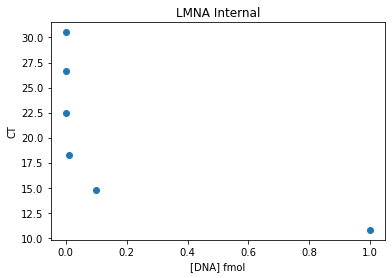

In [139]:
# Fit Standard Curves
target = 'LMNA Internal'
df     =  my_Ct_results

data = df[(df['Target Name']==target) & (df['Task']=='Standard')]

x = data['Quantity']
y = data['Original Ct']

plt.scatter(x,y)
        
plt.title(target)
plt.xlabel('[DNA] fmol')
plt.ylabel('CT')
plt.show()

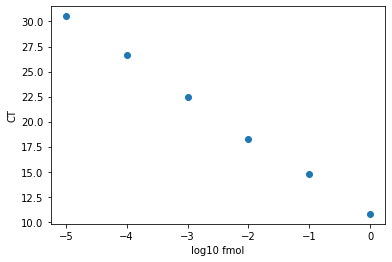

In [140]:
# Fit Standard Curves
target = 'LMNA Internal'
df     =  my_Ct_results

data = df[(df['Target Name']==target) & (df['Task']=='Standard')]

x = data['Quantity']
y = data['Original Ct']

plt.scatter(np.log10(x),y)
        
plt.xlabel('log10 fmol')
plt.ylabel('CT')
plt.show()

-3.956143 10.685050333333333 -0.9997104964965883 1.2570628575736882e-07


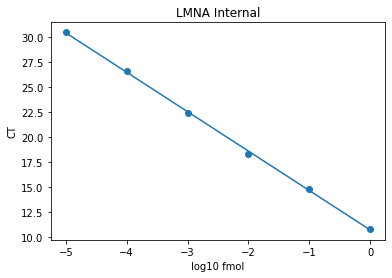

In [141]:
# Fit Standard Curves
target = 'LMNA Internal'
df     =  my_Ct_results

data = df[(df['Target Name']==target) & (df['Task']=='Standard')]

x = np.array(np.log10(data['Quantity']), dtype='float')
y = np.array(data['Original Ct'], dtype='float')

plt.scatter(x, y);

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(slope, intercept, r_value, p_value)

fit = slope * x + intercept

plt.plot(x, fit)
        
plt.title(target)
plt.xlabel('log10 fmol')
plt.ylabel('CT')
plt.show()

### For every, target, standard, threshold, we need a slope and and intercept.

We may as well save the r_value, p_value and std_err too

In [142]:
standards = my_Ct_results[my_Ct_results['Task']=='Standard']

grouped = standards.groupby(by=['Target Name', 'Biogroup Name'])

pairs = []

for pair, group in grouped:
    #print(pair)
    pairs.append(pair)

pairs
# These will not all be used to quantify.

[('ALFA_LMNA', 'ALFA-LMNA Plasmid'),
 ('ALFA_LMNA', 'ALFA-SpyT-LMNA Plasmid'),
 ('ALFA_LMNA', 'WT LMNA Plasmid'),
 ('GFP11_LMNA', 'GFP11-LMNA Plasmid'),
 ('GFP11_LMNA', 'GFP11-SpyT-LMNA Plasmid'),
 ('GFP11_LMNA', 'WT LMNA Plasmid'),
 ('LMNA Internal', 'WT LMNA Plasmid'),
 ('SpyTag_LMNA', 'ALFA-SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'GFP11-SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'WT LMNA Plasmid')]

In [143]:
valid_pairs = pairs[0:2] + pairs[3:5] + pairs[6:10]
valid_pairs

[('ALFA_LMNA', 'ALFA-LMNA Plasmid'),
 ('ALFA_LMNA', 'ALFA-SpyT-LMNA Plasmid'),
 ('GFP11_LMNA', 'GFP11-LMNA Plasmid'),
 ('GFP11_LMNA', 'GFP11-SpyT-LMNA Plasmid'),
 ('LMNA Internal', 'WT LMNA Plasmid'),
 ('SpyTag_LMNA', 'ALFA-SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'GFP11-SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'SpyT-LMNA Plasmid')]

In [144]:
def fit_standards(quantities, CTs, plot=True, color='b'):

    x = np.array(np.log10(quantities), dtype='float')
    y = np.array(CTs, dtype='float')

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    fit = slope * x + intercept

    if plot:
        plt.scatter(x, y, c=color);
        plt.gca().plot(x, fit, c=color)
        
    return slope, intercept, r_value, p_value, std_err

In [145]:
standards

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.00000,10.7819,10.707516636961287,11.206080395526243
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.10000,14.7766,14.689455560537265,15.18939026280521
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.01000,18.2721,18.190679308041165,18.660424630540927
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.00100,22.4681,22.364042970335397,22.91463401116235
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.00010,26.6304,26.542662209893862,27.09963702561525
...,...,...,...,...,...,...,...,...,...,...
241,K2,ALFA-SpyT-LMNA Plasmid,ALFA-SpyT-LMNA Plasmid,SpyTag_LMNA,blue,Standard,0.10000,15.474,15.395050656585367,15.97858729709941
242,K3,ALFA-SpyT-LMNA Plasmid,ALFA-SpyT-LMNA Plasmid,SpyTag_LMNA,blue,Standard,0.01000,18.9983,19.018772396518067,19.4475749868415
243,K4,ALFA-SpyT-LMNA Plasmid,ALFA-SpyT-LMNA Plasmid,SpyTag_LMNA,blue,Standard,0.00100,23.383,23.365761654057383,23.959493488117577
244,K5,ALFA-SpyT-LMNA Plasmid,ALFA-SpyT-LMNA Plasmid,SpyTag_LMNA,blue,Standard,0.00010,26.9692,26.97038089741482,27.470681992577756


In [146]:
data

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.00000,10.7819,10.707516636961287,11.206080395526243
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.10000,14.7766,14.689455560537265,15.18939026280521
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.01000,18.2721,18.190679308041165,18.660424630540927
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.00100,22.4681,22.364042970335397,22.91463401116235
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.00010,26.6304,26.542662209893862,27.09963702561525
5,A6,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.00001,30.5234,30.410140685732895,31.006286197927157


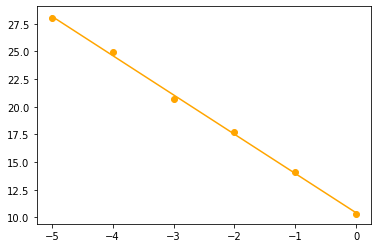

In [147]:
target   = 'ALFA_LMNA'
biogroup = 'ALFA-LMNA Plasmid'
Ct_type  = 'Original Ct'

data = standards[(standards['Target Name']==target) & (standards['Biogroup Name']==biogroup)]

quantities = data['Quantity']
CTs        = data[Ct_type]
color      = data['Target Color'].unique()[0]

slope, intercept, r_value, p_value, std_err = fit_standards(quantities, CTs, plot=True, color=color)

In [148]:
fit_data = []

for Ct_type in ['Original Ct', 'Lo thresh Ct', 'Hi thresh Ct']:
    
    for target, biogroup in valid_pairs:
        
        data = standards[(standards['Target Name']==target) & (standards['Biogroup Name']==biogroup)]

        quantities = data['Quantity']
        CTs        = data[Ct_type]
        color      = data['Target Color'].unique()[0]

        slope, intercept, r_value, p_value, std_err = fit_standards(quantities, CTs, plot=False)
        
        row = [target, biogroup, color, Ct_type, slope, intercept, r_value, p_value, std_err]
        
        fit_data.append(row)

fit_df = pd.DataFrame (fit_data, columns=['Target Name', 'Biogroup Name', 'Target Color', 'Ct Type', 'Slope', 'Intercept', 'R value', 'P value', 'Standard Error'])
fit_df

,Target Name,Biogroup Name,Target Color,Ct Type,Slope,Intercept,R value,P value,Standard Error
0,ALFA_LMNA,ALFA-LMNA Plasmid,orange,Original Ct,-3.553127,10.419796,-0.999164,1.047281e-06,0.072676
1,ALFA_LMNA,ALFA-SpyT-LMNA Plasmid,orange,Original Ct,-3.808705,10.488753,-0.999429,4.882395e-07,0.064358
2,GFP11_LMNA,GFP11-LMNA Plasmid,green,Original Ct,-3.717449,10.789487,-0.997798,7.267024e-06,0.123550
3,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,green,Original Ct,-4.116008,13.614589,-0.999355,6.237825e-07,0.073949
4,LMNA Internal,WT LMNA Plasmid,grey,Original Ct,-3.956143,10.685050,-0.999710,1.257063e-07,0.047608
5,SpyTag_LMNA,ALFA-SpyT-LMNA Plasmid,blue,Original Ct,-3.745522,11.874832,-0.999407,5.272379e-07,0.064519
6,SpyTag_LMNA,GFP11-SpyT-LMNA Plasmid,blue,Original Ct,-3.808848,13.284353,-0.998910,1.781058e-06,0.088986
7,SpyTag_LMNA,SpyT-LMNA Plasmid,blue,Original Ct,-3.562069,10.616604,-0.999684,1.493535e-07,0.044754
8,ALFA_LMNA,ALFA-LMNA Plasmid,orange,Lo thresh Ct,-3.566138,10.337121,-0.999044,1.369358e-06,0.078007
9,ALFA_LMNA,ALFA-SpyT-LMNA Plasmid,orange,Lo thresh Ct,-3.814102,10.431306,-0.999440,4.705620e-07,0.063857


In [149]:
## With the slope and intercept for a given standard, we can quantify our samples

## We want to quantify every sample, based on each relevant standard curve

## This will involve intersecting 'my_Ct_results' with 'fit_df'

In [150]:
target   = 'GFP11_LMNA'

fit_df[fit_df['Target Name']==target]

# There are two biogroups, and three Ct Types for this target

,Target Name,Biogroup Name,Target Color,Ct Type,Slope,Intercept,R value,P value,Standard Error
2,GFP11_LMNA,GFP11-LMNA Plasmid,green,Original Ct,-3.717449,10.789487,-0.997798,7.267024e-06,0.123550
3,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,green,Original Ct,-4.116008,13.614589,-0.999355,6.237825e-07,0.073949
10,GFP11_LMNA,GFP11-LMNA Plasmid,green,Lo thresh Ct,-3.723368,10.736368,-0.997254,1.130420e-05,0.138262
11,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,green,Lo thresh Ct,-4.127428,13.600350,-0.999175,1.020420e-06,0.083875
18,GFP11_LMNA,GFP11-LMNA Plasmid,green,Hi thresh Ct,-3.765169,11.290355,-0.998116,5.323407e-06,0.115738
19,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,green,Hi thresh Ct,-4.215219,14.192603,-0.999365,6.041951e-07,0.075129


In [151]:
my_Ct_results[my_Ct_results['Target Name']==target]

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
48,C1,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,1.0000,34.3712,34.32270563316416,35.02644262070774
49,C2,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,0.1000,36.344,36.2947756579007,37.02597826614165
50,C3,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,0.0100,Undetermined,nan,nan
51,C4,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,0.0010,Undetermined,nan,nan
52,C5,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,0.0001,Undetermined,nan,nan
...,...,...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,green,Unknown,NaN,26.5364,26.048953219212997,26.503262334302196
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.5364,24.94473930693364,25.487153501977645
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.6383,24.94290398858772,25.563120810983616
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.1406,24.61299581193691,25.125526767065985


In [152]:
## Try a single case
target   = 'GFP11_LMNA'
biogroup = 'GFP11-LMNA Plasmid'
Ct_type  = 'Original Ct'

fit_data = fit_df[(fit_df['Target Name']==target) & (fit_df['Biogroup Name']==biogroup) & (fit_df['Ct Type']==Ct_type)]

# get slope and intercept from fit_df
[slope, intercept] = fit_data[['Slope', 'Intercept']].values[0]
print(slope, intercept)

-3.7174488571428563 10.789486523809524


In [153]:
# get CT from my_Ct_results
target_Ct_data = my_Ct_results[(my_Ct_results['Target Name']==target)]
Ct_data        = target_Ct_data[Ct_type]

Ct_data        = pd.to_numeric(Ct_data, errors='coerce')
Ct_data

48     34.371200
49     36.344030
50           NaN
51           NaN
52           NaN
         ...    
354    26.536386
380    25.536352
381    25.638279
382    25.140633
383    24.823195
Name: Original Ct, Length: 70, dtype: float64

In [154]:
# Estimate quantities based on CT?
def quant_from_CT(CT, slope, intercept):
    
    quant = (CT - intercept) / slope
    
    return quant    

In [155]:
quant_from_CT(Ct_data, slope, intercept)

48    -6.343521
49    -6.874215
50          NaN
51          NaN
52          NaN
         ...   
354   -4.235942
380   -3.966932
381   -3.994350
382   -3.860483
383   -3.775091
Name: Original Ct, Length: 70, dtype: float64

In [156]:
target_quantitation_df = target_Ct_data.iloc[:,0:6].copy()
target_quantitation_df['Ct Type']  = Ct_type
target_quantitation_df['Quantity'] = quant_from_CT(Ct_data, slope, intercept)
target_quantitation_df['log10 (fmol)'] = 10**target_quantitation_df['Quantity']
target_quantitation_df

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,Quantity,log10 (fmol)
48,C1,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,-6.343521,4.533978e-07
49,C2,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,-6.874215,1.335933e-07
50,C3,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN,NaN
51,C4,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN,NaN
52,C5,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN,NaN
...,...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,green,Unknown,Original Ct,-4.235942,5.808414e-05
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,-3.966932,1.079117e-04
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,-3.994350,1.013094e-04
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,-3.860483,1.378851e-04


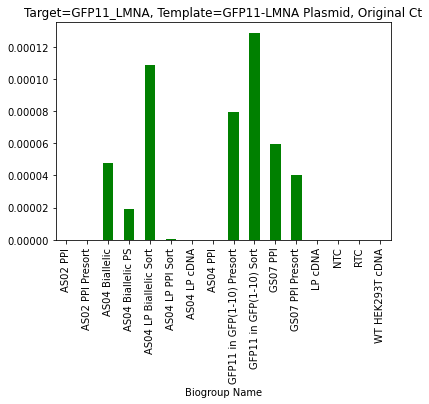

In [157]:
# Plot that sucka
color = target_quantitation_df['Target Color'].unique()[0]

unknowns = target_quantitation_df[target_quantitation_df['Task']!='Standard']
grouped  = unknowns.drop(columns=['Quantity']).groupby('Biogroup Name').mean().plot.bar(color=color)
plt.legend().remove()
plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

In [158]:
# Write a function for one case
def quantification_on_standards(target, biogroup, Ct_type):
    
    fit_data = fit_df[(fit_df['Target Name']==target) & (fit_df['Biogroup Name']==biogroup) & (fit_df['Ct Type']==Ct_type)]

    # get slope and intercept from fit_df
    [slope, intercept] = fit_data[['Slope', 'Intercept']].values[0]
    
    # get CT from my_Ct_results
    target_Ct_data = my_Ct_results[(my_Ct_results['Target Name']==target)]
    Ct_data        = target_Ct_data[Ct_type]

    Ct_data        = pd.to_numeric(Ct_data, errors='coerce')
    
    target_quantitation_df = target_Ct_data.iloc[:,0:6].copy()
    target_quantitation_df['Ct Type']  = Ct_type
    target_quantitation_df['log10 (fmol)'] = pd.to_numeric(10**quant_from_CT(Ct_data, slope, intercept), errors='coerce')
    
    color = target_quantitation_df['Target Color'].unique()[0]

    unknowns = target_quantitation_df[target_quantitation_df['Task']!='Standard']
    grouped  = unknowns.groupby('Biogroup Name').mean().plot.bar(color=color)
    plt.legend().remove()
    plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

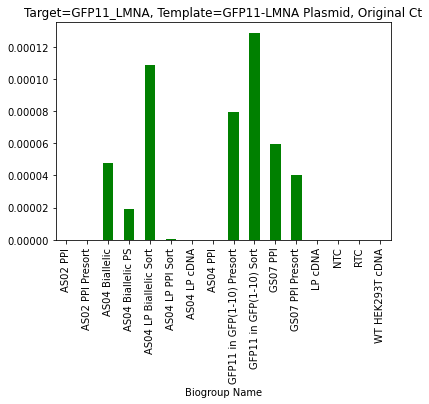

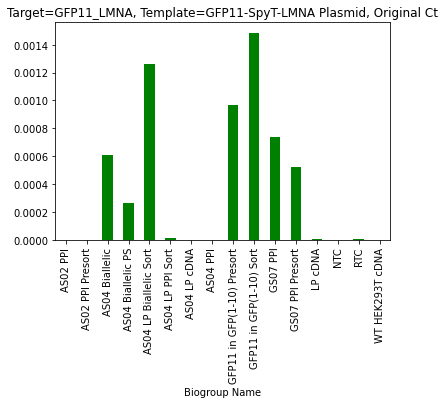

In [159]:
## Using the Original Cts quantitations are an order of magnitute different
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-LMNA Plasmid', Ct_type='Original Ct')
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-SpyT-LMNA Plasmid', Ct_type='Original Ct')

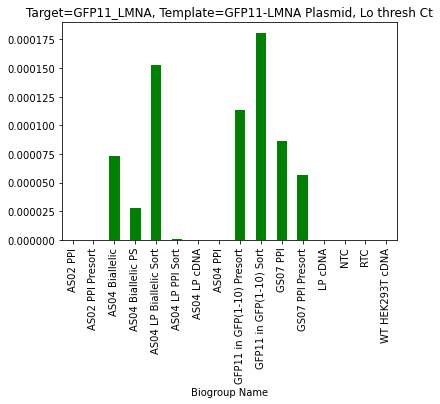

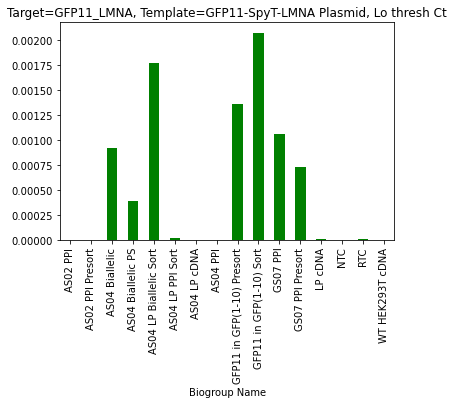

In [160]:
## This is not resolved by altering the threshold method
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-LMNA Plasmid', Ct_type='Lo thresh Ct')
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-SpyT-LMNA Plasmid', Ct_type='Lo thresh Ct')

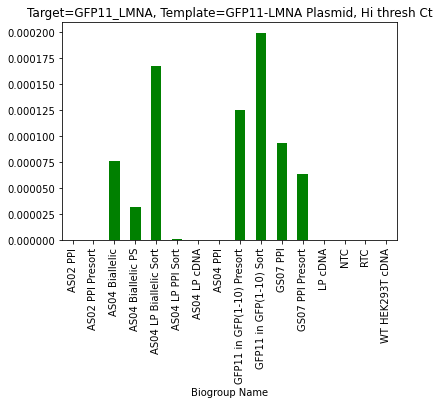

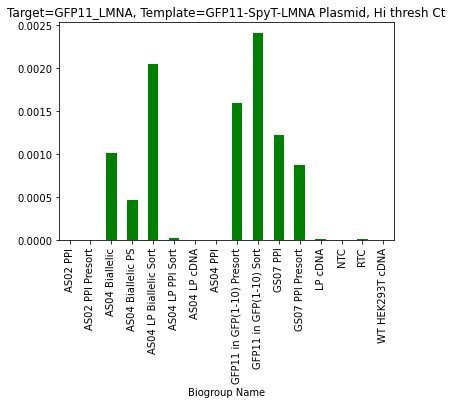

In [161]:
## This is not resolved by altering the threshold method
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-LMNA Plasmid', Ct_type='Hi thresh Ct')
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-SpyT-LMNA Plasmid', Ct_type='Hi thresh Ct')

## Step 4 - Analyse Melt Curves

In [162]:
melt_curve_data = raw[sheet_names[5]]

melt_curve_df = get_dataframe(melt_curve_data, header_position)

melt_curve_df = melt_curve_df.drop(columns=['Target Name']).merge(info, on='Well Position')
melt_curve_df

,Well,Well Position,Reading,Temperature,Fluorescence,Derivative,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity
0,1,A1,1,71.9999,420995,16234.2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
1,1,A1,2,72.2255,417698,16362.5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
2,1,A1,3,72.4512,415390,16506.5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
3,1,A1,4,72.6768,410732,16629,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
4,1,A1,5,72.9024,406955,16699.3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39163,384,P24,98,93.9242,-3433.55,-349.639,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN
39164,384,P24,99,94.1502,-4400.84,-406.404,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN
39165,384,P24,100,94.3763,-3367.71,-437.417,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN
39166,384,P24,101,94.6023,-3821.43,-455.884,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN


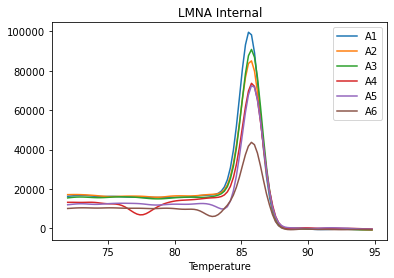

In [163]:
conditions = {'Target Name' : 'LMNA Internal' , 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)

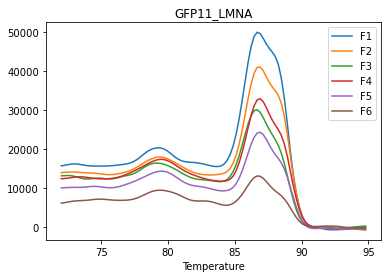

In [164]:
conditions = {'Target Name' : 'GFP11_LMNA', 'Biogroup Name': 'GFP11-LMNA Plasmid', 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)

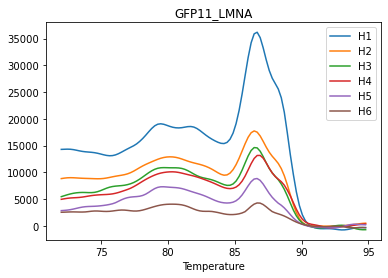

In [165]:
# For the lower concentrations of GFP11-SpyT-LMNA Plasmid, 
# the GFP11_LMNA primer set cannot distinguish between the target and non-specific products
conditions = {'Target Name' : 'GFP11_LMNA', 'Biogroup Name': 'GFP11-SpyT-LMNA Plasmid', 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)

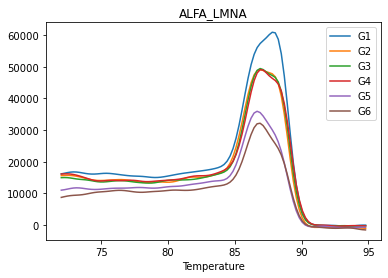

In [166]:
conditions = {'Target Name' : 'ALFA_LMNA', 'Biogroup Name': 'ALFA-LMNA Plasmid', 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)
# The amplification curves a a bit messier

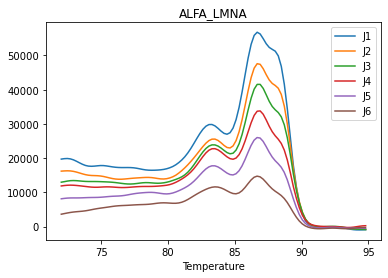

In [167]:

conditions = {'Target Name' : 'ALFA_LMNA', 'Biogroup Name': 'ALFA-SpyT-LMNA Plasmid', 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)
# Cleaner amplification curves, but a substantial side product

In [168]:
## Save the DataFrames
amplification_df.to_pickle('annotated_amplification_df.pkl')
melt_curve_df.to_pickle('annotated_melt_curve_df.pkl')
my_Ct_results.to_pickle('annotated_Ct_results_df.pkl')
fit_df.to_pickle('annotated_fit_df.pkl')

In [ ]:
## Load the local DataFrames
# amplification_df = pd.read_pickle('annotated_amplification_df.pkl')
# melt_curve_df    = pd.read_pickle('annotated_melt_curve_df.pkl')
# my_Ct_results    = pd.read_pickle('annotated_Ct_results_df.pkl')
# fit_df           = pd.read_pickle('annotated_fit_df.pkl')

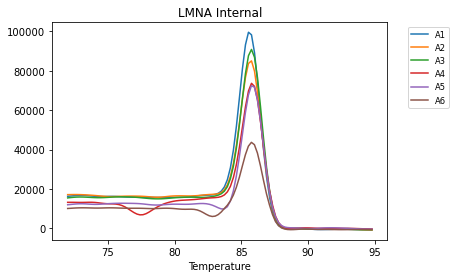

In [80]:
target = 'LMNA Internal'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

fig, ax = plt.subplots()

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative', ax = ax)
    ax.legend(standard_wells['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title(target)
plt.show()

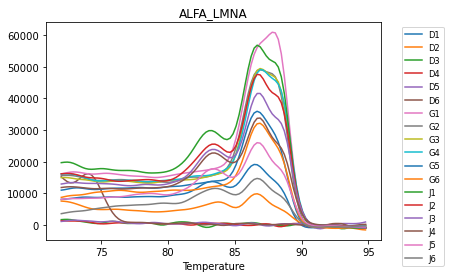

In [81]:
target = 'ALFA_LMNA'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

fig, ax = plt.subplots()

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative', ax = ax)
    ax.legend(standard_wells['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title(target)
plt.show()

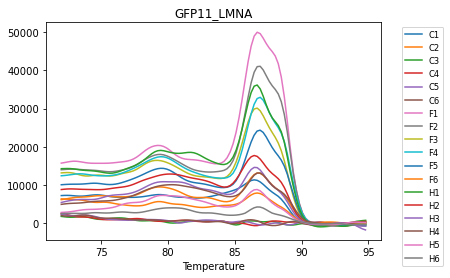

In [82]:
target = 'GFP11_LMNA'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

fig, ax = plt.subplots()

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative', ax = ax)
    ax.legend(standard_wells['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title(target)
plt.show()

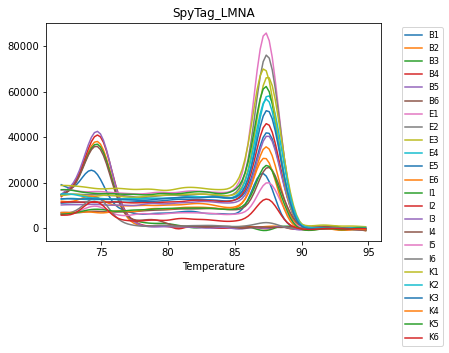

In [83]:
target = 'SpyTag_LMNA'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

fig, ax = plt.subplots()

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative', ax = ax)
    ax.legend(standard_wells['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title(target)
plt.show()

In [ ]:
## Which rows have the side hit ?

C:\Users\PythonWork\envs\HybriSeq\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\PythonWork\envs\HybriSeq\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\PythonWork\envs\HybriSeq\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

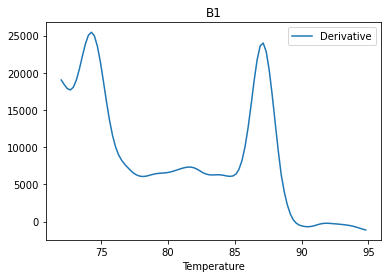

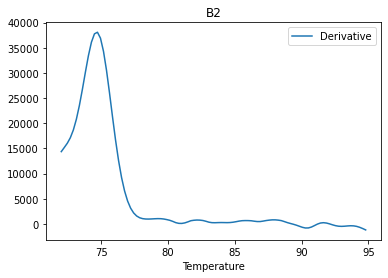

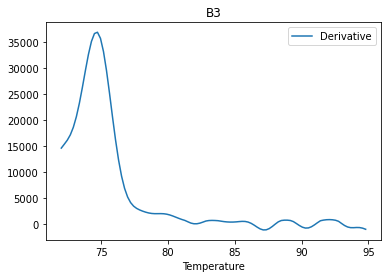

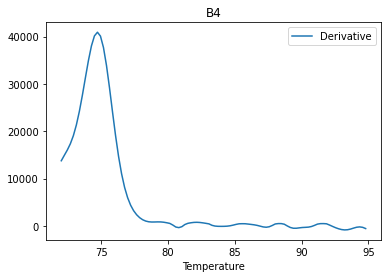

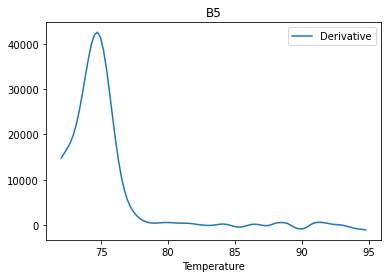

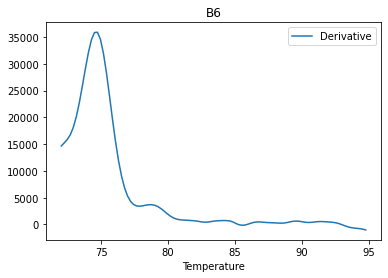

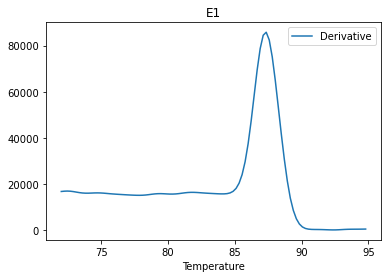

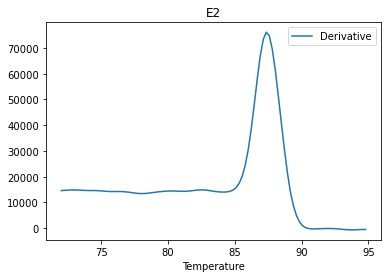

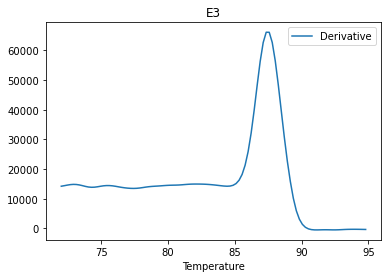

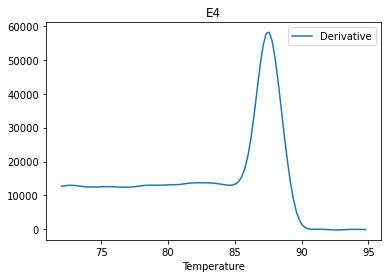

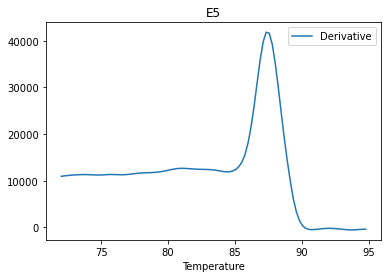

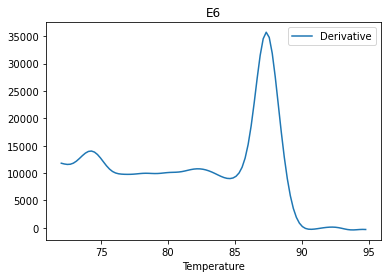

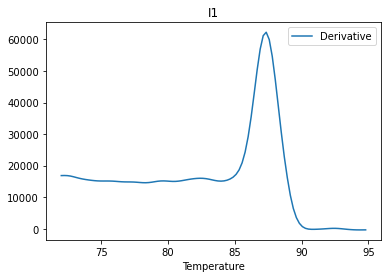

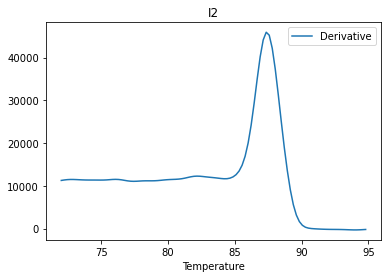

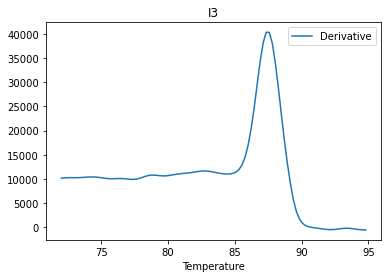

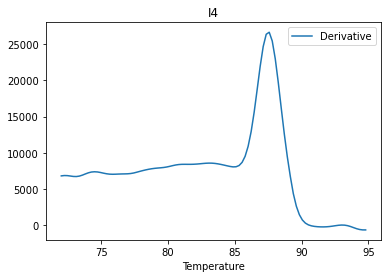

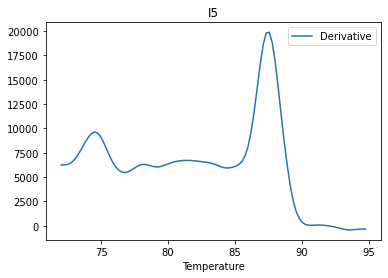

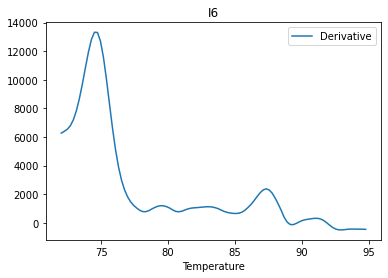

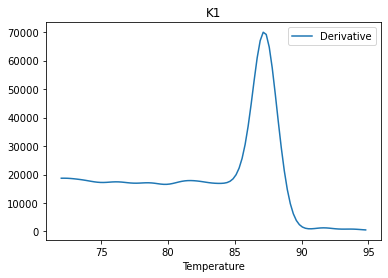

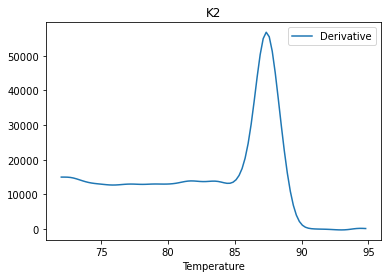

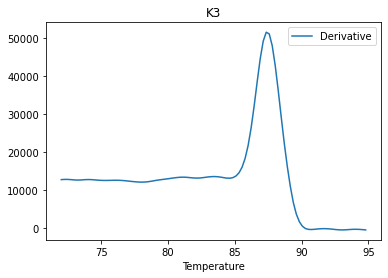

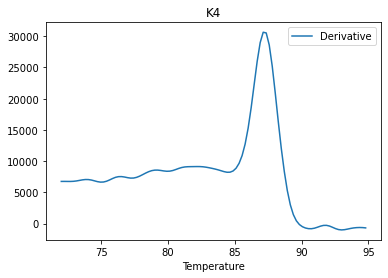

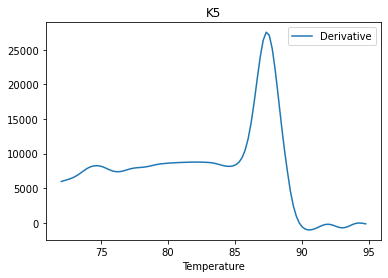

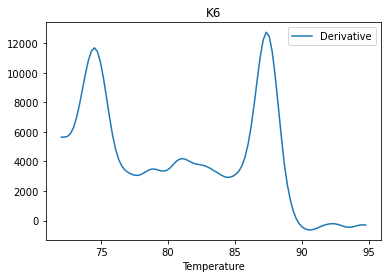

In [84]:
target = 'SpyTag_LMNA'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative')
    plt.title(key)
    
# B2 - B6 have the side hit
# So do I6 and K6

In [85]:
issue_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'I6', 'K6']

my_sample_df[my_sample_df['Well Position'].isin(issue_list)]

,Unnamed: 0,Well,Well Position,Sample Name,Sample Color,Biogroup Name,Biogroup Color,Target Name,Target Color,Task,Reporter,Quencher,Quantity,Comments
25,25,26,B2,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,blue,Standard,None,None,0.10000,None
26,26,27,B3,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,blue,Standard,None,None,0.01000,None
27,27,28,B4,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,blue,Standard,None,None,0.00100,None
28,28,29,B5,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,blue,Standard,None,None,0.00010,None
29,29,30,B6,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,blue,Standard,None,None,0.00001,None
197,197,198,I6,GFP11-SpyT-LMNA Plasmid,None,GFP11-SpyT-LMNA Plasmid,None,SpyTag_LMNA,blue,Standard,None,None,0.00001,None
245,245,246,K6,ALFA-SpyT-LMNA Plasmid,None,ALFA-SpyT-LMNA Plasmid,None,SpyTag_LMNA,blue,Standard,None,None,0.00001,None


In [ ]:
## SpyTag_LMNA primers give a week non-specific signal at low annealing temps. Strongest with the WT plasmid

## Step 5 - Organise the plots by experiment

In [86]:
fit_df

,Target Name,Biogroup Name,Target Color,Ct Type,Slope,Intercept,R value,P value,Standard Error
0,ALFA_LMNA,ALFA-LMNA Plasmid,orange,Original Ct,-3.553127,10.419796,-0.999164,1.047281e-06,0.072676
1,ALFA_LMNA,ALFA-SpyT-LMNA Plasmid,orange,Original Ct,-3.808705,10.488753,-0.999429,4.882395e-07,0.064358
2,GFP11_LMNA,GFP11-LMNA Plasmid,green,Original Ct,-3.717449,10.789487,-0.997798,7.267024e-06,0.123550
3,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,green,Original Ct,-4.116008,13.614589,-0.999355,6.237825e-07,0.073949
4,LMNA Internal,WT LMNA Plasmid,grey,Original Ct,-3.956143,10.685050,-0.999710,1.257063e-07,0.047608
5,SpyTag_LMNA,ALFA-SpyT-LMNA Plasmid,blue,Original Ct,-3.745522,11.874832,-0.999407,5.272379e-07,0.064519
6,SpyTag_LMNA,GFP11-SpyT-LMNA Plasmid,blue,Original Ct,-3.808848,13.284353,-0.998910,1.781058e-06,0.088986
7,SpyTag_LMNA,SpyT-LMNA Plasmid,blue,Original Ct,-3.562069,10.616604,-0.999684,1.493535e-07,0.044754
8,ALFA_LMNA,ALFA-LMNA Plasmid,orange,Lo thresh Ct,-3.566138,10.337121,-0.999044,1.369358e-06,0.078007
9,ALFA_LMNA,ALFA-SpyT-LMNA Plasmid,orange,Lo thresh Ct,-3.814102,10.431306,-0.999440,4.705620e-07,0.063857


In [87]:
my_Ct_results

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,1.0000,10.7819,10.707516636961287,11.206080395526243
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.1000,14.7766,14.689455560537265,15.18939026280521
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.0100,18.2721,18.190679308041165,18.660424630540927
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.0010,22.4681,22.364042970335397,22.91463401116235
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,0.0001,26.6304,26.542662209893862,27.09963702561525
...,...,...,...,...,...,...,...,...,...,...
379,P20,None,None,None,None,None,NaN,Undetermined,nan,nan
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.5364,24.94473930693364,25.487153501977645
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.6383,24.94290398858772,25.563120810983616
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.1406,24.61299581193691,25.125526767065985


In [88]:
unknowns = my_Ct_results[my_Ct_results['Task'].eq('Unknown')]
unknowns

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
7,A8,AS02 PPI PS sgRNA1 Rep1,AS02 PPI Presort,LMNA Internal,grey,Unknown,NaN,25.5584,25.00824558201031,25.46065465506177
8,A9,AS02 PPI PS sgRNA1 Rep2,AS02 PPI Presort,LMNA Internal,grey,Unknown,NaN,25.6342,25.109857433226317,25.558861379917513
9,A10,AS02 PPI PS sgRNA2 Rep1,AS02 PPI Presort,LMNA Internal,grey,Unknown,NaN,25.6805,25.16645533098514,25.592600693957436
10,A11,AS02 PPI PS sgRNA2 Rep2,AS02 PPI Presort,LMNA Internal,grey,Unknown,NaN,26.1656,25.584217419232502,26.07599460090727
13,A14,GS PPI PS sgRNA1 Rep1,GS07 PPI Presort,LMNA Internal,grey,Unknown,NaN,25.0878,24.43157671891215,25.02418038403872
...,...,...,...,...,...,...,...,...,...,...
378,P19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,ALFA_LMNA,orange,Unknown,NaN,26.2364,25.711725812227453,26.206032495688728
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.5364,24.94473930693364,25.487153501977645
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.6383,24.94290398858772,25.563120810983616
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,NaN,25.1406,24.61299581193691,25.125526767065985


In [89]:
unknowns['Biogroup Name'].unique()

array(['AS02 PPI Presort', 'GS07 PPI Presort', 'AS04 Biallelic PS',
       'AS02 PPI', 'AS04 PPI', 'GS07 PPI ', 'AS04 Biallelic',
       'WT HEK293T cDNA', 'LP cDNA', 'AS04 LP cDNA', 'AS04 LP PPI Sort',
       'AS04 LP Biallelic Sort', 'GFP11 in GFP(1-10) Presort',
       'GFP11 in GFP(1-10) Sort'], dtype=object)

In [90]:
## Start with GFP11
target   = 'GFP11_LMNA'
biogroup = 'GFP11-LMNA Plasmid'
Ct_type  = 'Original Ct'

In [91]:
# Write a function for one case
def quantification_df_from_standards(target, biogroup, Ct_type):
    
    fit_data = fit_df[(fit_df['Target Name']==target) & (fit_df['Biogroup Name']==biogroup) & (fit_df['Ct Type']==Ct_type)]

    # get slope and intercept from fit_df
    [slope, intercept] = fit_data[['Slope', 'Intercept']].values[0]
    
    # get CT from my_Ct_results
    target_Ct_data = my_Ct_results[(my_Ct_results['Target Name']==target)]
    Ct_data        = target_Ct_data[Ct_type]

    Ct_data        = pd.to_numeric(Ct_data, errors='coerce')
    
    target_quantitation_df = target_Ct_data.iloc[:,0:6].copy()
    target_quantitation_df['Ct Type']  = Ct_type
    target_quantitation_df['log10 (fmol)'] = pd.to_numeric(10**quant_from_CT(Ct_data, slope, intercept), errors='coerce')
    
    color = target_quantitation_df['Target Color'].unique()[0]

    unknowns = target_quantitation_df[target_quantitation_df['Task']!='Standard']
    grouped  = unknowns.groupby('Biogroup Name').mean().plot.bar(color=color)
    plt.legend().remove()
    plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);
    
    return target_quantitation_df

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
48,C1,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,4.533978e-07
49,C2,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,1.335933e-07
50,C3,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN
51,C4,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN
52,C5,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN
...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,green,Unknown,Original Ct,5.808414e-05
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,1.079117e-04
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,1.013094e-04
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,1.378851e-04


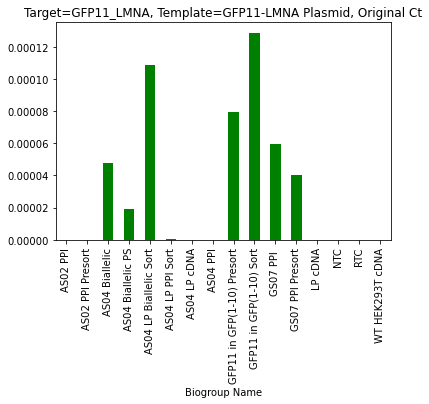

In [92]:
GFP11_LMNA_1 = quantification_df_from_standards(target='GFP11_LMNA', biogroup='GFP11-LMNA Plasmid', Ct_type='Original Ct')
GFP11_LMNA_1

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
48,C1,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,0.000009
49,C2,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,0.000003
50,C3,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN
51,C4,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN
52,C5,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,green,Standard,Original Ct,NaN
...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,green,Unknown,Original Ct,0.000725
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,0.001269
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,0.001199
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,0.001584


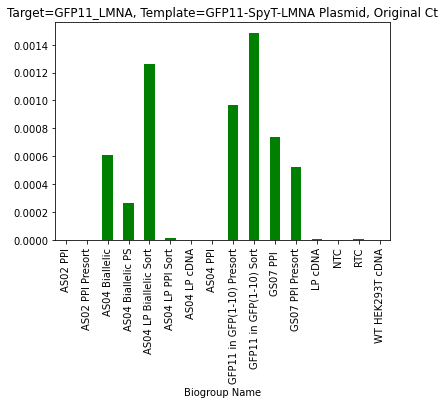

In [93]:
GFP11_LMNA_2 = quantification_df_from_standards(target='GFP11_LMNA', biogroup='GFP11-SpyT-LMNA Plasmid', Ct_type='Original Ct')
GFP11_LMNA_2

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,Original Ct,9.452083e-01
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,Original Ct,9.242318e-02
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,Original Ct,1.208367e-02
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,Original Ct,1.050967e-03
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,Original Ct,9.321038e-05
5,A6,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,grey,Standard,Original Ct,9.670289e-06
7,A8,AS02 PPI PS sgRNA1 Rep1,AS02 PPI Presort,LMNA Internal,grey,Unknown,Original Ct,1.739552e-04
8,A9,AS02 PPI PS sgRNA1 Rep2,AS02 PPI Presort,LMNA Internal,grey,Unknown,Original Ct,1.664461e-04
9,A10,AS02 PPI PS sgRNA2 Rep1,AS02 PPI Presort,LMNA Internal,grey,Unknown,Original Ct,1.620247e-04
10,A11,AS02 PPI PS sgRNA2 Rep2,AS02 PPI Presort,LMNA Internal,grey,Unknown,Original Ct,1.221716e-04


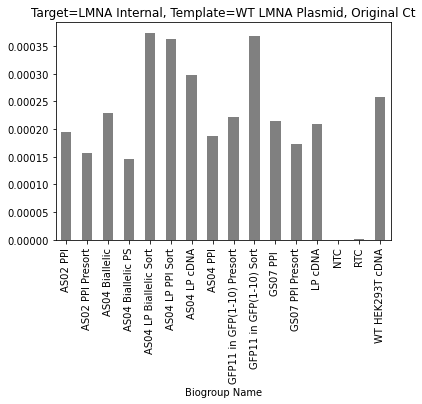

In [95]:
LMNA = quantification_df_from_standards(target='LMNA Internal', biogroup='WT LMNA Plasmid', Ct_type='Original Ct')
LMNA

In [96]:
test = LMNA.groupby('Biogroup Name').agg(['mean', 'std'])

In [98]:
test

log10 (fmol)          
                                    mean       std
Biogroup Name                                     
AS02 PPI                    1.945743e-04  0.000036
AS02 PPI Presort            1.561494e-04  0.000023
AS04 Biallelic              2.295983e-04  0.000037
AS04 Biallelic PS           1.466826e-04  0.000024
AS04 LP Biallelic Sort      3.742503e-04  0.000177
AS04 LP PPI Sort            3.632640e-04  0.000095
AS04 LP cDNA                2.975437e-04  0.000029
AS04 PPI                    1.876653e-04  0.000096
GFP11 in GFP(1-10) Presort  2.227757e-04  0.000060
GFP11 in GFP(1-10) Sort     3.681147e-04  0.000069
GS07 PPI                    2.154049e-04  0.000022
GS07 PPI Presort            1.739554e-04  0.000060
LP cDNA                     2.085015e-04  0.000096
NTC                         2.531766e-07       NaN
RTC                         1.788265e-06       NaN
WT HEK293T cDNA             2.586983e-04  0.000049
WT LMNA Plasmid             1.751448e-01  0.378960

In [104]:
group_order = ['WT HEK293T cDNA', 
              'GFP11 in GFP(1-10) Presort',
              'GFP11 in GFP(1-10) Sort']

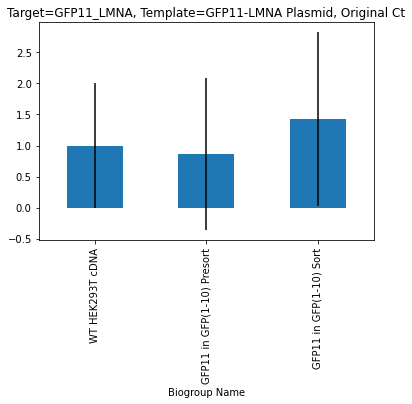

In [105]:
norm = test / test.loc['WT HEK293T cDNA', :]

norm.loc[group_order, :].plot.bar(y=0, yerr=norm.iloc[:,1])
    
plt.legend().remove()
plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

In [106]:
group_order = ['WT HEK293T cDNA',
               'GFP11 in GFP(1-10) Presort',
               'GFP11 in GFP(1-10) Sort',
               'GS PPI Presort',
              'GS07 PPI']

In [524]:
# Plot LMNA with error bars
def plot_quantitation(target_quantitation_df, order):
    
    color = target_quantitation_df['Target Color'].unique()[0]

    agg_df  = target_quantitation_df.groupby('Biogroup Name').agg(['mean', 'std'])
    
    #Reorder df
    agg_df.loc[order, :].plot.bar(y=0, yerr=agg_df.iloc[:,1], color=color)
    
    plt.legend().remove()
    plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);
    
    return agg_df

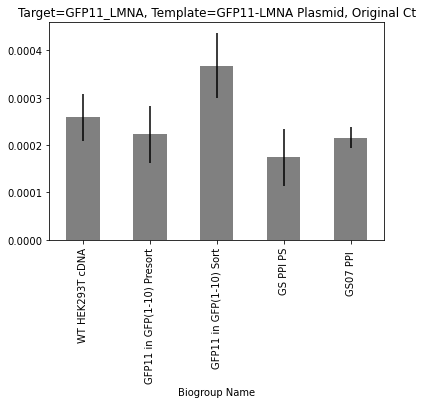

In [514]:
LMNA_agg_df = plot_quantitation(LMNA, group_order)

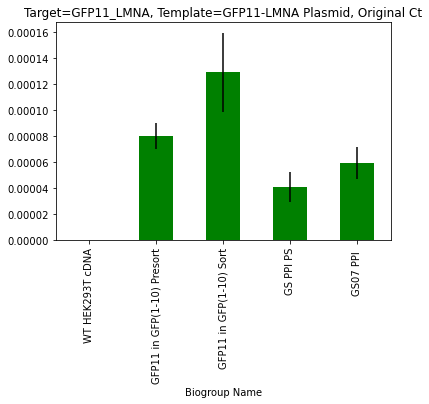

In [515]:
GFP11_LMNA_1_agg_df = plot_quantitation(GFP11_LMNA_1, group_order)

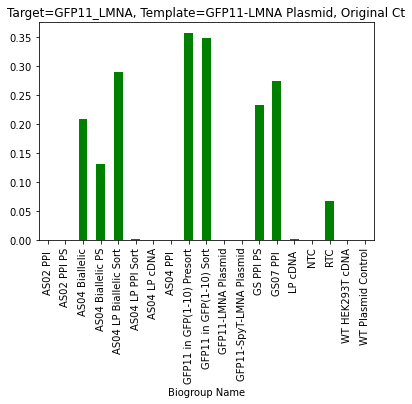

In [519]:
ratio = GFP11_LMNA_1_agg_df / LMNA_agg_df

ratio.plot.bar(y=0, color=color)
    
plt.legend().remove()
plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

## Biallelic Figure Plot

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
72,D1,WT Plasmid Control,WT Plasmid Control,ALFA_LMNA,orange,Standard,Original Ct,2.203014e-06
73,D2,WT Plasmid Control,WT Plasmid Control,ALFA_LMNA,orange,Standard,Original Ct,5.260797e-08
74,D3,WT Plasmid Control,WT Plasmid Control,ALFA_LMNA,orange,Standard,Original Ct,NaN
75,D4,WT Plasmid Control,WT Plasmid Control,ALFA_LMNA,orange,Standard,Original Ct,NaN
76,D5,WT Plasmid Control,WT Plasmid Control,ALFA_LMNA,orange,Standard,Original Ct,NaN
...,...,...,...,...,...,...,...,...
373,P14,AS04 LP PPI Sort 2,AS04 LP PPI Sort,ALFA_LMNA,orange,Unknown,Original Ct,6.863930e-05
375,P16,AS04 LP Biallelic Sort 1,AS04 LP Biallelic Sort,ALFA_LMNA,orange,Unknown,Original Ct,8.637712e-05
376,P17,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,ALFA_LMNA,orange,Unknown,Original Ct,1.020003e-04
377,P18,AS04 LP Biallelic Sort 1,AS04 LP Biallelic Sort,ALFA_LMNA,orange,Unknown,Original Ct,4.184218e-05


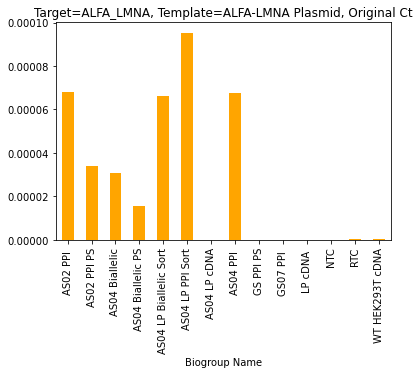

In [521]:
ALFA_1 = quantification_df_from_standards(target='ALFA_LMNA', biogroup='ALFA-LMNA Plasmid', Ct_type='Original Ct')
ALFA_1

In [528]:
biallelic_group_order = ['WT HEK293T cDNA', 'AS04 Biallelic PS', 'AS04 Biallelic', 'AS04 LP Biallelic Sort', 'AS04 LP cDNA', 'LP cDNA ', 'RTC', 'NTC']

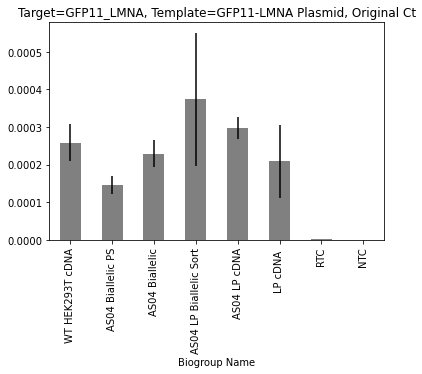

In [534]:
LMNA_for_bi = plot_quantitation(LMNA, biallelic_group_order)

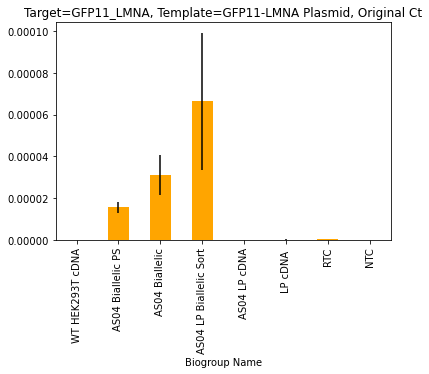

In [536]:
ALFA_for_bi = plot_quantitation(ALFA_1, biallelic_group_order)

In [542]:
ratio

log10 (fmol)               
                                     mean            std
Biogroup Name                                           
ALFA-LMNA Plasmid                     NaN            NaN
ALFA-SpyT LMNA Plasmid                NaN            NaN
AS02 PPI                         2.866215       1.665063
AS02 PPI PS                      4.599766       4.664207
AS04 Biallelic                   7.421292       3.871977
AS04 Biallelic PS                9.381752       9.376285
AS04 LP Biallelic Sort           5.636695       5.388004
AS04 LP PPI Sort                 3.809968       4.767416
AS04 LP cDNA                  5887.009462    1067.619640
AS04 PPI                         2.779738       2.520909
GFP11 in GFP(1-10) Presort            NaN            NaN
GFP11 in GFP(1-10) Sort               NaN            NaN
GS PPI PS                     2499.350951     904.112974
GS07 PPI                      1859.696715     463.641856
LP cDNA                       1873.095246     826.837838
NTC                                   NaN            NaN
RTC                              6.638839            NaN
WT HEK293T cDNA               1859.979299            NaN
WT Plasmid Control          222685.339586  308852.388056

In [541]:
ratio = LMNA_for_bi / ALFA_for_bi

ratio.plot.bar(y=0, color='orange')
    
plt.legend().remove()
plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

TypeError: '['WT HEK293T cDNA', 'AS04 Biallelic PS', 'AS04 Biallelic', 'AS04 LP Biallelic Sort', 'AS04 LP cDNA', 'LP cDNA ', 'RTC', 'NTC']' is an invalid key

## How should we present this data?

In [418]:
# Reorganise plot
GFP11_LMNA_1

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
48,C1,WT Plasmid Control,WT Plasmid Control,GFP11_LMNA,green,Standard,Original Ct,4.533978e-07
49,C2,WT Plasmid Control,WT Plasmid Control,GFP11_LMNA,green,Standard,Original Ct,1.335933e-07
50,C3,WT Plasmid Control,WT Plasmid Control,GFP11_LMNA,green,Standard,Original Ct,NaN
51,C4,WT Plasmid Control,WT Plasmid Control,GFP11_LMNA,green,Standard,Original Ct,NaN
52,C5,WT Plasmid Control,WT Plasmid Control,GFP11_LMNA,green,Standard,Original Ct,NaN
...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,green,Unknown,Original Ct,5.808414e-05
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,1.079117e-04
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,1.013094e-04
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,green,Unknown,Original Ct,1.378851e-04


In [412]:
test['Biogroup Name'].unique()

array(['WT Plasmid Control', 'AS02 PPI PS', 'GS PPI PS',
       'AS04 Biallelic PS', 'GFP11-LMNA Plasmid',
       'GFP11-SpyT-LMNA Plasmid', 'AS02 PPI ', 'AS04 PPI ', 'GS07 PPI ',
       'AS04 Biallelic', 'GFP11 in GFP(1-10) Presort', 'WT HEK293T cDNA',
       'LP cDNA ', 'AS04 LP cDNA', 'NTC', 'RTC', 'AS04 LP PPI Sort',
       'AS04 LP Biallelic Sort', 'GFP11 in GFP(1-10) Sort'], dtype=object)

In [ ]:

# Plot every row
for row in rows:

    fig, ax = plt.subplots()

    grouped = melt_curve_df.groupby('Well Position')

    for key, group in grouped:

        if key in row:
            group.plot(x='Temperature', y='Derivative', ax = ax)
            ax.legend(row, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            
    plt.show()

In [ ]:
#Get subsets of data
Results = data[["Sample Name", "Task", "CT"]]
#Rename the column names to get rid of "blank"
Results_header = ["Sample", "Task", "CT"]
Results.columns = Results_header
Results

In [ ]:
#clean up data by NTC, CT bigger than NTC is considered untrustable
Results2 = Results.sort_values("CT")
Results2.reset_index(drop=True)

In [ ]:
# get the upper and lower limit for valuable samples
index1 = input("starting index number, such as type 0 to get the first line. ")
index2 = input("ending index number such as type 16 to get the 16th line, indexed as 15. ")

In [ ]:
a = int(index1)
b = int(index2)
Result = Results2.iloc[a:b, :]
Result

In [ ]:
#Generate standard curve，need to convert datatype into float for math function
Standards = Result.loc[Result["Task"] == 'STANDARD'].copy()
Standards["conc"] = Standards.Sample.apply(lambda x:  x[0:-2])
Standards.conc = Standards.conc.astype("float")
Standards["log10_conc"] = Standards.conc.apply(lambda x: np.log10(x))
Standards.CT = Standards.CT.astype("float")
Standards

In [ ]:
#Generate standard curve，need to convert datatype into float for math function
Standards = Result.loc[Result["Task"] == 'STANDARD']
Standards["conc"] = Standards.Sample.apply(lambda x:  x[0:-2])
Standards.conc = Standards.conc.astype("float")
Standards["log10_conc"] = Standards.conc.apply(lambda x: np.log10(x))
Standards.CT = Standards.CT.astype("float")
Standards

In [ ]:
#use linear regression function from scipy package 
slope, intercept, r_value, p_value, std_err = stats.linregress(Standards.log10_conc, Standards.CT)
print("slope:%f intercept:%f p_value: %f std_err:%f " % (slope, intercept, p_value, std_err))
k = slope
b = intercept
std = std_err

In [ ]:
#plot standard curve
plt.scatter(Standards.log10_conc, Standards.CT)
plt.plot(Standards.log10_conc, (k*Standards.log10_conc+b));

#Add axis labels
plt.xlabel('log10 concentration');
plt.ylabel('CT');

#Add a title
plt.title('Standard Curve Fitting');

In [ ]:
#Get the probe concentration of UNKNOWN data
unknown = Result.loc[Result["Task"] == 'UNKNOWN'].copy()
unknown['conc'] = unknown.CT.apply(lambda x: pow(10, (x-b)/k) )
unknown

In [ ]:
Mean = unknown.groupby("Sample").mean()

In [ ]:
unknown.to_excel("Output_2020-02-06_lib quantify.xlsx")
Mean.to_excel("Output_Mean_2020-02-06_lib quantify.xlsx")